In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
def plot_option_prices(initial_stock_prices, volatilities, option_prices_meshgrid,
                       elevation=10, initial_azimuth=230, title=None):

    initial_stock_prices_grid, volatilities_grid = np.meshgrid(initial_stock_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_stock_prices_grid,
                              volatilities_grid,
                              option_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Stock Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Option Price', rotation=90)
    
    print(title + ':')
    
    plt.show()
    

def plot_option_price_modes():

    for mode in option_prices_meshgrid:

        plot_option_prices(initial_stock_prices, volatilities, option_prices_meshgrid[mode], title=mode)

In [3]:
def simple_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                       risk_free_interest_rate, dividend_rate, 
                       volatility, option_type, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    samples = np.zeros(samples_count) 
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    stock_prices = initial_stock_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences[price_differences < 0] = 0
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices

In [4]:
# Fixed

T = time_to_maturity = 1

q = dividend_rate = 0.05
r = risk_free_interest_rate = 0.02

CallPut = option_type = 'Call'

### 5) 10 Initial Prices - 10 Volatilities - 1M Samples - 1K Top Bins

In [7]:
DATASET_FILE = 'simulated_prices/option_probabilities_100K.csv'

# initial_stock_prices = np.linspace(0, 1000, 11)
initial_stock_prices = [500]

volatilities = np.linspace(0, 1.0, 11)

samples_count = 1000000

histogram_bins_count = samples_count
top_bins_count = 1000

time_steps_count = 300
strike_price = 100

volatilities

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Simulating:   0%|                                                               | 0/1 [00:00<?, ?simulation/s]

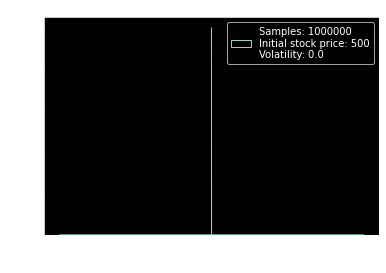

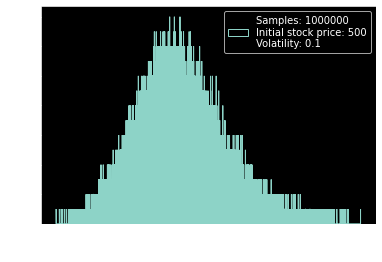

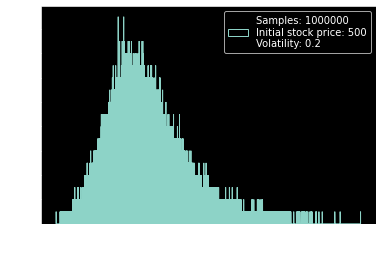

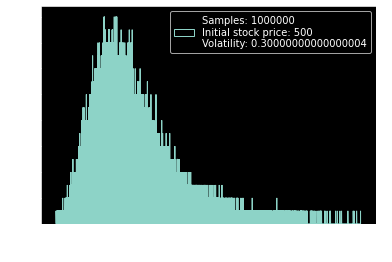

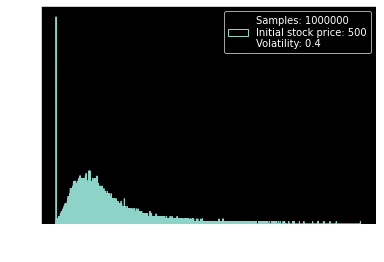

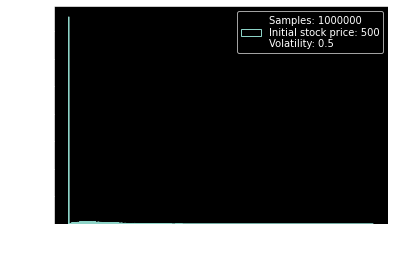

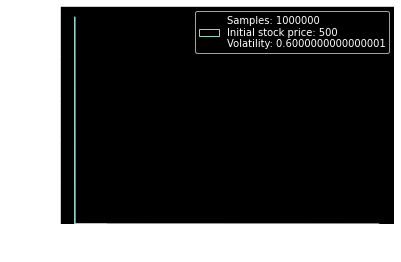

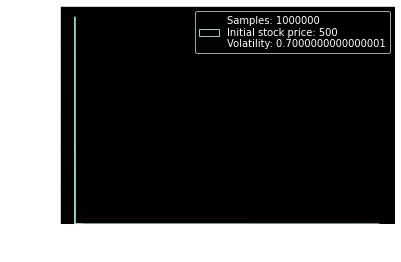

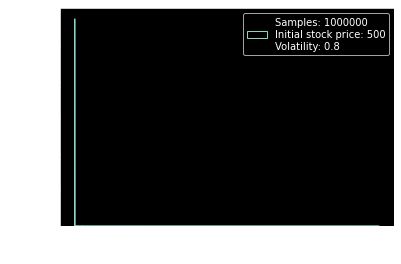

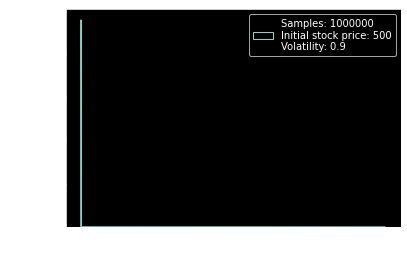

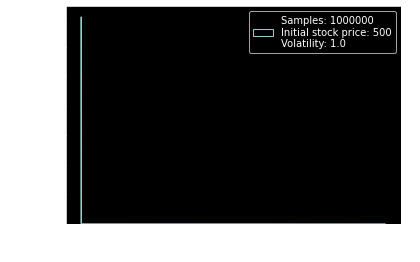

Simulating: 100%|███████████████████████████████████████████████████████| 1/1 [01:17<00:00, 77.61s/simulation]


In [8]:
from collections import defaultdict

np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price,probability',
           comments='',
           # fmt='%s', delimiter=' ',
          )

option_prices_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = defaultdict(lambda: np.zeros(option_prices_shape))

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1
)    

for i, initial_stock_price in enumerate(simulation_tracker):

    for j, volatility in enumerate(volatilities):

        option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
           
        # Meshgrid
        
        option_prices_meshgrid['Minimum option prices'][i, j] = option_prices.min()
        option_prices_meshgrid['Maximum option prices'][i, j] = option_prices.max()
        
        
        # Histogram

        samples_per_bin, bin_edges = np.histogram(option_prices, bins=histogram_bins_count)

        bin_width = bin_edges[1] - bin_edges[0]

        option_price_bins = bin_centers = bin_edges[:-1] + bin_width / 2

        probabilities = samples_per_bin / samples_count
        
        
        # Top bins
        
        pairs = np.vstack((option_price_bins, probabilities)).T
                
        descending_indices = np.argsort(pairs[:, 1])[::-1]
        
        sorted_pairs = pairs[descending_indices]
        
        top_sorted_pairs = sorted_pairs[:top_bins_count]
        
        top_option_prices = top_sorted_pairs[:, 0]
        top_probabilities = top_sorted_pairs[:, 1]
       
        option_prices_meshgrid['Most probable option prices'][i, j] = top_option_prices[0]
        option_prices_meshgrid['Most probable option price means'][i, j] = top_option_prices.mean()
        option_prices_meshgrid['Most probable option price weighted means'][i, j] = (top_option_prices * 
                                                                                     top_probabilities).mean()
        
        # Plot
        
#         plt.bar(top_option_prices, top_probabilities,
#                     # bins=top_bins_count,
#                     # # density=True,
#                     # histtype='step', 
#                     label=f"{samples_count} samples");

#         plt.xlabel("Top option price")
#         plt.ylabel("Probability")
#         plt.legend()
#         plt.show()
        
        plt.hist(option_prices,
                 bins=samples_count,
                 # # density=True,
                 histtype='step', 
                 label=f"Samples: {samples_count}\n"
                       f"Initial stock price: {initial_stock_price}\n"
                       f"Volatility: {volatility}");

        plt.xlabel("Option price")
        plt.ylabel("Samples count")
        plt.legend()
        plt.show() 
        
        


        
        
        
        
        # print("top_option_prices[0]:", top_option_prices[0])
        # print("top_option_prices.mean():", top_option_prices.mean())
        
        # print("bin_centers:\n", bin_centers)        
        # print("samples_per_bin:\n", samples_per_bin, samples_per_bin.sum())
        # print("probabilities:\n", probabilities, probabilities.sum())
        # print("pairs:\n", pairs)
        # print("descending_indices:\n", descending_indices.shape)        
        # print("sorted_pairs:\n", sorted_pairs)
        # print("top_sorted_pairs:\n", top_sorted_pairs)
        
        # print("top_option_prices:", top_option_prices)
        # print("top_probabilities:", top_probabilities)
        

        # Batches

        initial_stock_price_batch = np.full(top_bins_count, initial_stock_price)

        volatility_batch = np.full(top_bins_count, volatility)

        sample_batch = np.vstack((initial_stock_price_batch,
                                  volatility_batch,
                                  top_option_prices,
                                  top_probabilities)).T

        with open(DATASET_FILE, 'ab') as dataset_file:
            np.savetxt(dataset_file, sample_batch, fmt=('%d', '%f', '%f', '%f'), delimiter=',')

In [7]:
# # Histogram

# plt.hist(top_option_prices,
#          bins=top_bins_count,
#          # density=True,
#          histtype='step', 
#          label=f"{samples_count} samples");

# plt.xlabel("Option price")
# plt.ylabel("Samples")
# plt.legend();

In [10]:
# plot_option_price_modes()

### 4) 101 Initial Prices - 101 Volatilities - 1M Samples - With Mean

In [34]:
DATASET_FILE = 'simulated_prices/option_prices_1M_samples.csv'

initial_stock_prices = np.linspace(0, 10000, 101)
volatilities = np.linspace(0, 1.0, 101)

samples_count = 10000

time_steps_count = 300

strike_price = 1000


fields_count = 3

option_prices_shape = (len(initial_stock_prices) * len(volatilities), fields_count)

option_prices = np.zeros(option_prices_shape)

option_prices_meshgrid_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_meshgrid_shape)


np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price',
           comments='')

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1    
)    

for initial_stock_price_index, initial_stock_price in enumerate(simulation_tracker):

    for volatility_index, volatility in enumerate(volatilities):

        sampled_option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
        
        option_price = sampled_option_prices.mean()
        
        # row = np.array([initial_stock_price, volatility, option_price])
        
        row = (initial_stock_price, volatility, option_price)
        
        option_price_index = initial_stock_price_index * len(initial_stock_prices) + volatility_index
        
        option_prices[option_price_index] = row
        
        # print(row)
           
        # Meshgrid
        
        option_prices_meshgrid[initial_stock_price_index, volatility_index] = option_price
        

with open(DATASET_FILE, 'ab') as dataset_file:
    np.savetxt(dataset_file, option_prices, fmt=('%d', '%f', '%f'), delimiter=',')

Simulating:   1%|▌                                                    | 1/101 [00:08<13:54,  8.35s/simulation]


KeyboardInterrupt: 

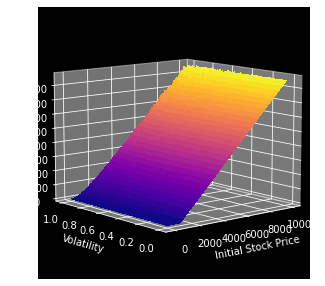

In [31]:
# Field grids

initial_stock_prices_grid, volatilities_grid = np.meshgrid(initial_stock_prices, volatilities)

# 3D Plot

ELEVATION = 10
INITIAL_AZIMUTH = 230

fig, ax = plt.subplots(figsize=(5, 5),
                       subplot_kw={"projection": "3d"})

surface = ax.plot_surface(initial_stock_prices_grid,
                          volatilities_grid,
                          option_prices_meshgrid.T,
                          cmap='plasma',
                          linewidth=30, 
                          antialiased=False)

ax.view_init(elev=ELEVATION, azim=INITIAL_AZIMUTH)


# ax.locator_params(axis='x', nbins=5)

ax.zaxis.set_rotate_label(False)

ax.set_xlabel('Initial Stock Price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price', rotation=90)

plt.show()

### 3) 101 Initial Prices - 101 Volatilities - 10000 Samples  

In [4]:
DATASET_FILE = 'simulated_prices/option_probabilities_10k.csv'

initial_stock_prices = np.linspace(0, 10000, 101)
volatilities = np.linspace(0, 1.0, 101)

samples_count = 1000
histogram_bins_count = 1000

time_steps_count = 300

strike_price = 1000


np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price,probability',
           comments='',
           # fmt='%s', delimiter=' ',
          )

option_prices_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_shape)

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation'
)    

for i, initial_stock_price in enumerate(simulation_tracker):

    for j, volatility in enumerate(volatilities):

        option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
           
        # Meshgrid
        
        option_prices_meshgrid[i, j] = option_prices.mean()
        
        # continue
        
        # Histogram

        samples_per_bin, bin_edges = np.histogram(option_prices, bins=histogram_bins_count)

        bin_width = bin_edges[1] - bin_edges[0]

        bin_centers = bin_edges[:-1] + bin_width / 2

        probabilities = samples_per_bin / samples_count

        # Batches

        initial_stock_price_batch = np.full(histogram_bins_count, initial_stock_price)

        volatility_batch = np.full(histogram_bins_count, volatility)

        option_price_bins = bin_centers

        option_price_probabilities = probabilities  

        sample_batch = np.vstack((initial_stock_price_batch,
                                  volatility_batch,
                                  option_price_bins,
                                  option_price_probabilities)).T

        with open(DATASET_FILE, 'ab') as dataset_file:
            np.savetxt(dataset_file, sample_batch, fmt=('%d', '%f', '%f', '%f'), delimiter=',')

Simulating: 100%|███████████████████████████████████████████████████| 101/101 [02:00<00:00,  1.20s/simulation]


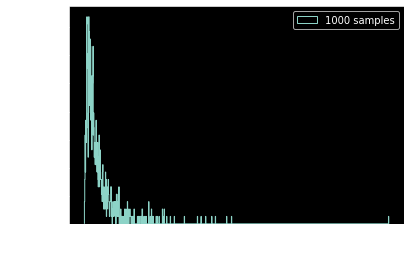

In [5]:
plt.hist(option_prices, 
         bins=histogram_bins_count,
         density=True,
         histtype='step', 
         label=f"{samples_count} samples");

plt.xlabel("Option price")
plt.ylabel("Probability")
plt.legend();

In [8]:
# 3D Plot

initial_stock_prices_grid, volatilities_grid = np.meshgrid(initial_stock_prices, volatilities)


ELEVATION = 10
INITIAL_AZIMUTH = 230

fig, ax = plt.subplots(figsize=(5, 5),
                       subplot_kw={"projection": "3d"})

surface = ax.plot_surface(initial_stock_prices_grid,
                          volatilities_grid,
                          option_prices_meshgrid.T,
                          cmap='plasma',
                          linewidth=30, 
                          antialiased=False)

ax.view_init(elev=ELEVATION, azim=INITIAL_AZIMUTH)


# ax.locator_params(axis='x', nbins=5)

ax.zaxis.set_rotate_label(False)

ax.set_xlabel('Initial Stock Price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price', rotation=90)

plt.show()

### 1) 1000000 Samples

In [11]:
BINS_COUNT = 100

simulations_count = 1
samples_count = 1000000
time_steps_count = 300

strike_price = -1000
initial_stock_price = 5000
volatility = 0.3


print("samples_count:", samples_count)    

mean_option_prices = []

simulation_tracker = tqdm.tqdm(
    range(simulations_count),
    desc=f"Simulating",
    ncols=110,
    unit='simulations'
)    

for simulation_index in simulation_tracker:

    option_prices = simple_monte_carlo(
        initial_stock_price=initial_stock_price, 
        strike_price=strike_price,
        time_to_maturity=time_to_maturity, 
        risk_free_interest_rate=risk_free_interest_rate,
        dividend_rate=dividend_rate, 
        volatility=volatility, 
        option_type=option_type, 
        time_steps_count=time_steps_count,
        samples_count=samples_count
    )
    
    mean_option_price = option_prices.mean()

samples_count: 1000000


Simulating: 100%|██████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/simulations]


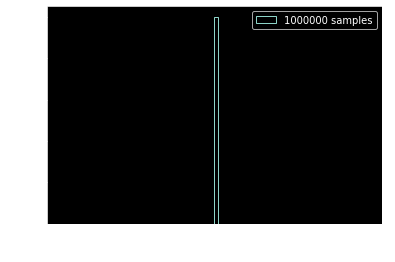

In [12]:
plt.hist(mean_option_price, 
         bins=BINS_COUNT,
         density=True,
         histtype='step', 
         label=f"{samples_count} samples");

plt.xlabel("Option price")
plt.ylabel("Probability")
plt.legend();

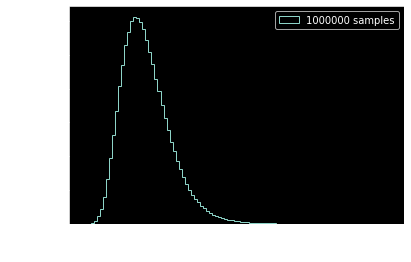

In [13]:
plt.hist(option_prices, 
         bins=BINS_COUNT,
         density=True,
         histtype='step', 
         label=f"{samples_count} samples");

plt.xlabel("Option price")
plt.ylabel("Probability")
plt.legend();

### 2) 1000 Simulations * 10000 Samples

In [15]:
SAMPLE_COUNTS = [10000]

BINS_COUNT = 100

simulations_count = 1000
time_steps_count = 300

strike_price = -1000
initial_stock_price = 5000
volatility = 0.3

means_per_simulation = dict()
options_per_simulation = dict()

for samples_count in SAMPLE_COUNTS:

    print("samples_count:", samples_count)    
    
    mean_option_prices = []

    simulation_tracker = tqdm.tqdm(
        range(simulations_count),
        desc=f"Simulating",
        ncols=110,
        unit='simulations'
    )    

    for simulation_index in simulation_tracker:

        option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
        
        mean_option_price = option_prices.mean()

        mean_option_prices.append(mean_option_price)
        
    means_per_simulation[samples_count] = mean_option_prices
    options_per_simulation[samples_count] = option_prices

samples_count: 10000


Simulating: 100%|████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.46simulations/s]


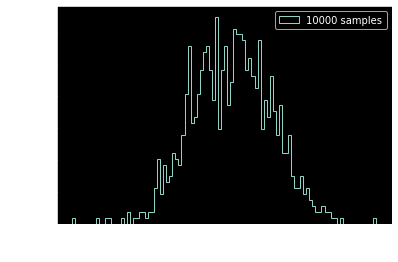

In [16]:
plt.hist(means_per_simulation[10000], 
         bins=BINS_COUNT,
         density=True,
         histtype='step', 
         label=f"{samples_count} samples");

plt.xlabel("Option price")
plt.ylabel("Probability")
plt.legend();

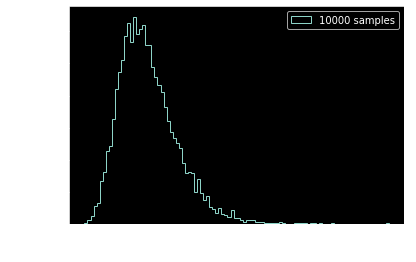

In [17]:
plt.hist(options_per_simulation[10000], 
         bins=BINS_COUNT,
         density=True,
         histtype='step', 
         label=f"{samples_count} samples");

plt.xlabel("Option price")
plt.ylabel("Probability")
plt.legend();

In [24]:
variance = np.var(means_per_simulation[10000])

variance

217.69666932757664

### Histogram per Samples count

Samples count: 1000


Sampling: 100%|██████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 28821.48 samples/s]


Samples count: 10000


Sampling: 100%|████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29843.14 samples/s]


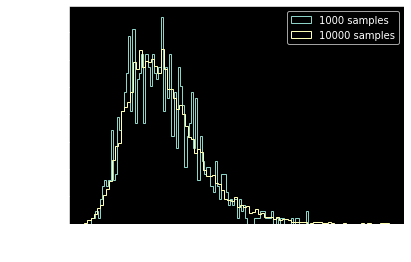

In [4]:
SAMPLES_COUNTS = [1000, 10000]
BINS_COUNT = 100

strike_price = -1000
initial_stock_price = 5000
volatility = 0.3

for samples_count in SAMPLES_COUNTS:
    
    print("Samples count:", samples_count)    
      
    sample_option_prices = []

    sample_tracker = tqdm.tqdm(
        range(samples_count),
        desc=f"Sampling",
        ncols=110,
        unit=' samples',
        # smoothing=0,
        # mininterval=1.0
    )    

    for sample_index in sample_tracker:

        sample_option_price, pathes = simple_monte_carlo(
            S=initial_stock_price, 
            K=strike_price,
            T=time_to_maturity, 
            r=risk_free_interest_rate,
            q=dividend_rate, 
            sigma=volatility, 
            CallPut=option_type, 
            n=time_steps_count,
            m=paths_count
        )

        sample_option_prices.append(sample_option_price)

    plt.hist(sample_option_prices, 
             bins=BINS_COUNT,
             density=True,
             histtype='step', 
             label=f"{samples_count} samples");

    
plt.xlabel("Option price")
plt.ylabel("Quantity")
plt.legend();

### Histogram per Pathes count

paths_count: 1000
paths_count: 10000


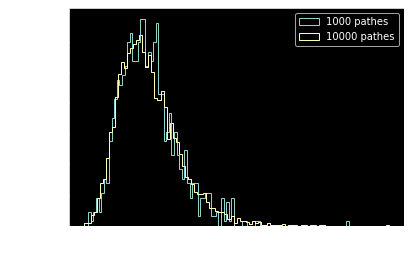

In [5]:
PATH_COUNTS = [1000, 10000]

BINS_COUNT = 100

strike_price = -1000
initial_stock_price = 5000
volatility = 0.3

for paths_count in PATH_COUNTS:

    print("paths_count:", paths_count)

    sample_option_prices = []
    
    sample_option_price, pathes = simple_monte_carlo(
        S=initial_stock_price, 
        K=strike_price,
        T=time_to_maturity, 
        r=risk_free_interest_rate,
        q=dividend_rate, 
        sigma=volatility, 
        CallPut=option_type, 
        n=time_steps_count,
        m=paths_count
    )

    sample_option_prices.append(sample_option_price)

    plt.hist(pathes, 
             bins=BINS_COUNT,
             density=True,
             histtype='step', 
             label=f"{paths_count} pathes");

    
plt.xlabel("Option price")
plt.ylabel("Quantity")
plt.legend();

### Sampling estimation

In [ ]:
duration = 360

simulation_sample_per_second = simulations_count * samples_count / duration

duration = simulations_count * samples_count / simulation_sample_per_second

In [ ]:
# 1)
#
# 1 S0, Sigma
# 1 Simulation
# 1000000 Samples
# No mean

# 2)
#
# 1 S0, Sigma
# 1000 Simulation
# 10000 Samples
# Mean prices histogram, variance np.var()

# 3)
#
# 1000 S0, Sigma
# 10000 Samples
# No mean

In [ ]:
### 